# Ball Tracking using Machine Learning

**Aim: To create models that predict each of runs and wickets using the remaining tracking features**

In [1]:
!pip install -U imbalanced-learn

In [2]:
!pip install xgboost

In [60]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics 
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

random_state = 1

**EDA - Exploratory Data Analysis**

Importing Data

In [4]:
data = pd.read_csv('data.csv')
data.head()   # to quickly view a small part of dataset

,release_speed_kph,swing_angle,deviation,release_position_y,release_position_z,bounce_position_y,bounce_position_x,crease_position_y,crease_position_z,stumps_position_y,stumps_position_z,bounce_velocity_ratio_z,release_angle,drop_angle,bounce_angle,batting_hand,bowling_hand,bowling_type,runs,wicket
0,87.42,-1.64,2.44,0.78,2.12,0.27,5.35,0.23,0.46,0.21,0.49,-0.50,-2.81,-15.69,8.78,left,right,spin,1,0
1,141.37,0.83,-0.36,-0.76,2.10,-0.15,7.29,0.19,0.71,0.27,0.80,-0.59,-8.88,-12.34,7.90,right,right,pace,1,0
2,133.41,-0.80,0.16,0.30,1.83,0.15,3.78,0.11,0.21,0.10,0.27,-0.47,-4.72,-9.53,4.91,right,left,pace,1,0
3,98.07,1.00,NaN,-0.99,2.00,-0.33,1.80,-0.30,0.13,-0.24,0.30,-0.65,-0.78,-13.29,9.18,right,left,spin,0,0
4,89.12,0.81,-2.45,-0.62,2.15,0.13,4.03,0.18,0.45,0.21,0.57,-0.57,-0.72,-16.55,10.25,right,right,spin,1,0


We are aware that if there is wicket then run will always be zero. Let's confirm from the given data.

In [5]:
data[((data['wicket']==1) & (data['runs']!=0))]   # No record will be shown

,release_speed_kph,swing_angle,deviation,release_position_y,release_position_z,bounce_position_y,bounce_position_x,crease_position_y,crease_position_z,stumps_position_y,stumps_position_z,bounce_velocity_ratio_z,release_angle,drop_angle,bounce_angle,batting_hand,bowling_hand,bowling_type,runs,wicket


Each row of the dataset represents one ball and the tracking attributes of that ball. Each row also contains the outcome of that ball i.e. runs and wickets.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200789 entries, 0 to 200788
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   release_speed_kph        200333 non-null  float64
 1   swing_angle              200534 non-null  float64
 2   deviation                194981 non-null  float64
 3   release_position_y       200527 non-null  float64
 4   release_position_z       200402 non-null  float64
 5   bounce_position_y        200465 non-null  float64
 6   bounce_position_x        200520 non-null  float64
 7   crease_position_y        200535 non-null  float64
 8   crease_position_z        200506 non-null  float64
 9   stumps_position_y        200523 non-null  float64
 10  stumps_position_z        200506 non-null  float64
 11  bounce_velocity_ratio_z  200496 non-null  float64
 12  release_angle            200533 non-null  float64
 13  drop_angle               200510 non-null  float64
 14  boun

Here we have:
    20 columns (0-19) including runs and wickets, 
    200789 total rows and, 
    Out of 20 columns 15 columns are float datatype, 3 columns are object and 2 columns are of integer datatype. 
    
It is required to convert column with object datatype to numeric datatype to be able to feed this data to the ML model. (It will be handled in feature engineering section).

Also, looking closely it can be noticed that our dataset contains few null values as well. 

Let's do more analysis and resolve issues!

In [7]:
data.describe()   # to view statistical distribution of the data

,release_speed_kph,swing_angle,deviation,release_position_y,release_position_z,bounce_position_y,bounce_position_x,crease_position_y,crease_position_z,stumps_position_y,stumps_position_z,bounce_velocity_ratio_z,release_angle,drop_angle,bounce_angle,runs,wicket
count,200333.000000,200534.000000,194981.000000,200527.000000,200402.000000,200465.000000,200520.000000,200535.000000,200506.000000,200523.000000,200506.000000,200496.000000,200533.000000,200510.000000,200509.000000,200789.000000,200789.000000
mean,113.314104,0.181257,-0.205346,-0.323727,2.003797,-0.141884,6.140859,-0.076211,0.668237,-0.059821,0.744015,-0.607788,-5.508132,-13.918712,9.529667,1.290763,0.049903
std,21.574559,1.225102,1.884765,0.636353,0.131172,0.336724,2.845008,0.341465,0.318014,0.366915,0.320691,0.077297,4.183278,2.615902,2.290649,1.626499,0.217745
min,40.200000,-24.500000,-24.080000,-3.000000,1.020000,-1.300000,-8.930000,-1.540000,0.000000,-1.800000,0.000000,-2.880000,-43.760000,-44.210000,0.020000,0.000000,0.000000
25%,90.810000,-0.480000,-0.860000,-0.750000,1.930000,-0.380000,4.470000,-0.290000,0.480000,-0.290000,0.560000,-0.650000,-8.340000,-15.790000,7.870000,0.000000,0.000000
50%,119.260000,0.190000,-0.040000,-0.570000,1.990000,-0.170000,6.120000,-0.080000,0.640000,-0.060000,0.720000,-0.610000,-5.270000,-13.950000,9.280000,1.000000,0.000000
75%,132.840000,0.880000,0.620000,0.160000,2.080000,0.080000,7.980000,0.140000,0.820000,0.170000,0.890000,-0.560000,-2.400000,-11.980000,10.970000,1.000000,0.000000
max,168.670000,24.360000,24.290000,2.980000,6.710000,1.300000,18.730000,1.900000,3.380000,1.950000,3.360000,0.000000,43.550000,-0.360000,44.220000,6.000000,1.000000


In [8]:
data.isna().sum().sum()

10441

In [9]:
data.duplicated().sum()

288

Duplicate data increases chances of overfitting and hence the model will not generalise well on test (unseen) data. So, it is better to remove the duplicates.

In [10]:
dup_data = data.duplicated(keep='first')
non_dup_data = data[~dup_data]
non_dup_data = non_dup_data.reset_index()
non_dup_data = non_dup_data.drop(columns=['index'])
non_dup_data

,release_speed_kph,swing_angle,deviation,release_position_y,release_position_z,bounce_position_y,bounce_position_x,crease_position_y,crease_position_z,stumps_position_y,stumps_position_z,bounce_velocity_ratio_z,release_angle,drop_angle,bounce_angle,batting_hand,bowling_hand,bowling_type,runs,wicket
0,87.42,-1.64,2.44,0.78,2.12,0.27,5.35,0.23,0.46,0.21,0.49,-0.50,-2.81,-15.69,8.78,left,right,spin,1,0
1,141.37,0.83,-0.36,-0.76,2.10,-0.15,7.29,0.19,0.71,0.27,0.80,-0.59,-8.88,-12.34,7.90,right,right,pace,1,0
2,133.41,-0.80,0.16,0.30,1.83,0.15,3.78,0.11,0.21,0.10,0.27,-0.47,-4.72,-9.53,4.91,right,left,pace,1,0
3,98.07,1.00,NaN,-0.99,2.00,-0.33,1.80,-0.30,0.13,-0.24,0.30,-0.65,-0.78,-13.29,9.18,right,left,spin,0,0
4,89.12,0.81,-2.45,-0.62,2.15,0.13,4.03,0.18,0.45,0.21,0.57,-0.57,-0.72,-16.55,10.25,right,right,spin,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200496,86.25,-2.68,3.90,1.10,1.81,0.24,5.51,0.14,0.60,0.12,0.66,-0.63,-1.26,-14.82,11.17,left,right,spin,6,0
200497,88.19,0.90,2.95,0.92,2.12,0.17,3.87,0.19,0.59,0.20,0.77,-0.71,-0.31,-16.44,13.51,left,right,spin,1,0
200498,128.75,2.05,-0.58,-0.39,1.96,-0.01,1.91,0.02,0.12,0.06,0.26,-0.66,-3.50,-10.14,7.10,right,right,pace,1,0
200499,135.15,1.22,-0.08,0.55,1.99,0.13,7.15,-0.03,0.75,-0.07,0.85,-0.68,-8.23,-11.44,8.36,right,left,pace,0,0


In [11]:
non_dup_data.columns

Index(['release_speed_kph', 'swing_angle', 'deviation', 'release_position_y',
       'release_position_z', 'bounce_position_y', 'bounce_position_x',
       'crease_position_y', 'crease_position_z', 'stumps_position_y',
       'stumps_position_z', 'bounce_velocity_ratio_z', 'release_angle',
       'drop_angle', 'bounce_angle', 'batting_hand', 'bowling_hand',
       'bowling_type', 'runs', 'wicket'],
      dtype='object')

In [12]:
non_dup_data.duplicated().sum()

0

In [13]:
num_null_vals = non_dup_data.isna().sum().sum()   # check if null values also removed with duplicate rows
num_null_vals

7782

In [14]:
non_dup_data.isna().sum()

release_speed_kph           279
swing_angle                  79
deviation                  5620
release_position_y           86
release_position_z          210
bounce_position_y           147
bounce_position_x            93
crease_position_y            77
crease_position_z           107
stumps_position_y            89
stumps_position_z           107
bounce_velocity_ratio_z     116
release_angle                80
drop_angle                  102
bounce_angle                104
batting_hand                  3
bowling_hand                110
bowling_type                373
runs                          0
wicket                        0
dtype: int64

In [15]:
perc_null_vals = (num_null_vals/len(non_dup_data))*100
perc_null_vals

3.8812774001127175

'deviation' column have the most null values. Instead of removing rows, it may be better to replace them with mean or median values. But in current model, we will be removing all nan values as nan values make only ~4% of the dataset.

Also, I would like experiment data with models that can handle missing data as well as with removed missing data.

**Visualisations**

In the given dataset, we have two target variables: 'runs' and 'wicket'. Let's check their distrubution in the dataset.

<AxesSubplot:>

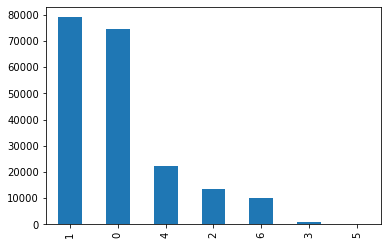

In [16]:
non_dup_data.runs.value_counts().plot(kind="bar")

<AxesSubplot:>

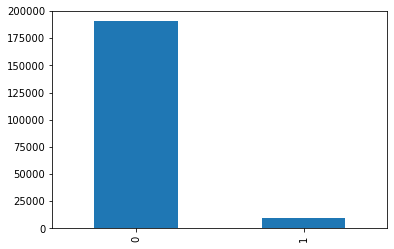

In [17]:
non_dup_data.wicket.value_counts().plot(kind="bar")

From the plots, it is clearly seen that our classes are highly **unbalanced** in both the cases (runs and wicket). This will be issue for the model as it will result in pretty high accuracy just by predicting the majority class, but will fail to capture the minority class. We will handle this problem in Feature Engineering section

Now, let's check **correlation** between the featues using heatmap

Correlation coefficient varies between -1 to 1. If the correlation coeffecient is:

negative: then features are negatively correlated, i.e., if one increases, another will decrease and vice-versa,

positive: then features are positively correlated, i.e., they will increase/ decrease in one direction, 

zero: then there is no correlation between features.

<AxesSubplot:>

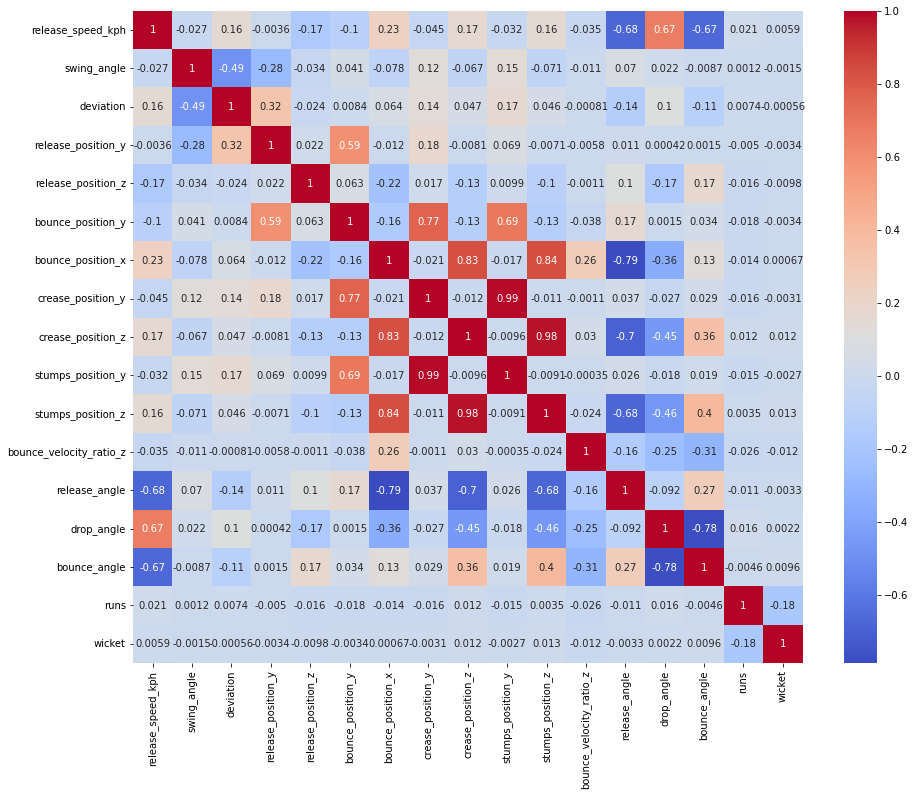

In [18]:
# let's check for whole dataset now

fig, ax = plt.subplots(figsize=(15,12)) 
sns.heatmap(non_dup_data.corr(), annot = True, fmt='.2g', cmap= 'coolwarm')

**Feature Engineering**

Tasks to be done in this section:

        1. Remove rows with nan values (duplicates have already been removed above),
        
        2. encoding: convert categorical columns('batting_hand', 'bowling_hand', 'bowling_type') to numeric features
        
        3. remove highly correlated features 
        
        4. normalise/ scale the distribution of features
        
        5. Resampling of Data (to resolve issue of unbalanced classes)
    
Note for resampling of data: If we remove data from majority class, there are chances that we loose useful information and if we make duplicates of minority class, it may cause over-fishing. Hence, we will be using SMOTE (Synthetic Minority Oversampling Technique). It creates synthetic points for minority class using K-nearest Neighbours technique.

In [19]:
# Removing nans:

clean_data = non_dup_data.dropna().reset_index()
clean_data = clean_data.drop(columns = 'index')
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193869 entries, 0 to 193868
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   release_speed_kph        193869 non-null  float64
 1   swing_angle              193869 non-null  float64
 2   deviation                193869 non-null  float64
 3   release_position_y       193869 non-null  float64
 4   release_position_z       193869 non-null  float64
 5   bounce_position_y        193869 non-null  float64
 6   bounce_position_x        193869 non-null  float64
 7   crease_position_y        193869 non-null  float64
 8   crease_position_z        193869 non-null  float64
 9   stumps_position_y        193869 non-null  float64
 10  stumps_position_z        193869 non-null  float64
 11  bounce_velocity_ratio_z  193869 non-null  float64
 12  release_angle            193869 non-null  float64
 13  drop_angle               193869 non-null  float64
 14  boun

In [20]:
len(non_dup_data)-len(clean_data)   # checking number of removed rows

6632

In [21]:
# Encoding:

cate_cols_data = clean_data.select_dtypes(include=['object'])
cate_cols = cate_cols_data.columns
clean_data[cate_cols].describe()

,batting_hand,bowling_hand,bowling_type
count,193869,193869,193869
unique,2,2,2
top,right,right,pace
freq,133036,139172,121039


In [22]:
cate_cols_data

,batting_hand,bowling_hand,bowling_type
0,left,right,spin
1,right,right,pace
2,right,left,pace
3,right,right,spin
4,right,left,spin
...,...,...,...
193864,left,right,spin
193865,left,right,spin
193866,right,right,pace
193867,right,left,pace


In [23]:
'''
# Each categorical column has only two unique values and all the data is being encoded at once. 
# So it is feasible to use ordinal encoder.
'''
ord_encoder = OrdinalEncoder()

encoded_cols = pd.DataFrame(ord_encoder.fit_transform(clean_data[cate_cols]), columns = cate_cols)
remv_cat_cols = clean_data.drop(columns=cate_cols)
encoded_dataframe = pd.concat([remv_cat_cols, encoded_cols], axis=1)
encoded_dataframe

,release_speed_kph,swing_angle,deviation,release_position_y,release_position_z,bounce_position_y,bounce_position_x,crease_position_y,crease_position_z,stumps_position_y,stumps_position_z,bounce_velocity_ratio_z,release_angle,drop_angle,bounce_angle,runs,wicket,batting_hand,bowling_hand,bowling_type
0,87.42,-1.64,2.44,0.78,2.12,0.27,5.35,0.23,0.46,0.21,0.49,-0.50,-2.81,-15.69,8.78,1,0,0.0,1.0,1.0
1,141.37,0.83,-0.36,-0.76,2.10,-0.15,7.29,0.19,0.71,0.27,0.80,-0.59,-8.88,-12.34,7.90,1,0,1.0,1.0,0.0
2,133.41,-0.80,0.16,0.30,1.83,0.15,3.78,0.11,0.21,0.10,0.27,-0.47,-4.72,-9.53,4.91,1,0,1.0,0.0,0.0
3,89.12,0.81,-2.45,-0.62,2.15,0.13,4.03,0.18,0.45,0.21,0.57,-0.57,-0.72,-16.55,10.25,1,0,1.0,1.0,1.0
4,96.64,0.32,0.71,-0.84,2.05,-0.01,5.36,0.32,0.50,0.42,0.57,-0.52,-2.52,-15.39,8.76,0,0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193864,86.25,-2.68,3.90,1.10,1.81,0.24,5.51,0.14,0.60,0.12,0.66,-0.63,-1.26,-14.82,11.17,6,0,0.0,1.0,1.0
193865,88.19,0.90,2.95,0.92,2.12,0.17,3.87,0.19,0.59,0.20,0.77,-0.71,-0.31,-16.44,13.51,1,0,0.0,1.0,1.0
193866,128.75,2.05,-0.58,-0.39,1.96,-0.01,1.91,0.02,0.12,0.06,0.26,-0.66,-3.50,-10.14,7.10,1,0,1.0,1.0,0.0
193867,135.15,1.22,-0.08,0.55,1.99,0.13,7.15,-0.03,0.75,-0.07,0.85,-0.68,-8.23,-11.44,8.36,0,0,1.0,0.0,0.0


In [24]:
encoded_dataframe.columns

Index(['release_speed_kph', 'swing_angle', 'deviation', 'release_position_y',
       'release_position_z', 'bounce_position_y', 'bounce_position_x',
       'crease_position_y', 'crease_position_z', 'stumps_position_y',
       'stumps_position_z', 'bounce_velocity_ratio_z', 'release_angle',
       'drop_angle', 'bounce_angle', 'runs', 'wicket', 'batting_hand',
       'bowling_hand', 'bowling_type'],
      dtype='object')

As more numeric featues are added, it will be good to see again the how the features are correlated

<AxesSubplot:>

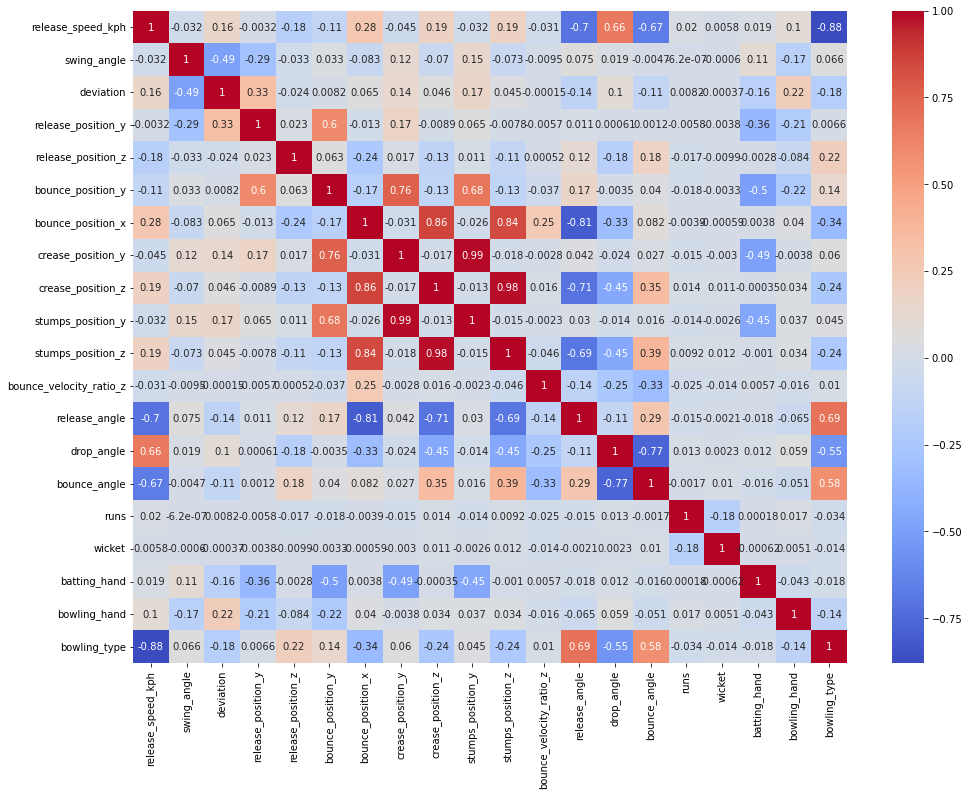

In [25]:
fig, ax = plt.subplots(figsize=(16,12)) 
sns.heatmap(encoded_dataframe.corr(), annot = True, fmt='.2g', cmap= 'coolwarm')

Here we have same features as above that are highly correlated - 'crease_position_y' with 'stumps_position_y' and 'crease_position_z' with 'stumps_position_z'. Highly correlated columns don't add any extra information, it's good to remove 'stumps_position_y' and 'stumps_position_z'.

In [26]:
corr_Matrix = encoded_dataframe.corr().abs()
corr_Matrix

,release_speed_kph,swing_angle,deviation,release_position_y,release_position_z,bounce_position_y,bounce_position_x,crease_position_y,crease_position_z,stumps_position_y,stumps_position_z,bounce_velocity_ratio_z,release_angle,drop_angle,bounce_angle,runs,wicket,batting_hand,bowling_hand,bowling_type
release_speed_kph,1.000000,3.193797e-02,0.157683,0.003173,0.179848,0.110590,0.279635,0.045277,0.187277,0.031847,0.192952,0.030650,0.703830,0.664390,0.670831,1.961335e-02,0.005822,0.019464,0.100468,0.879716
swing_angle,0.031938,1.000000e+00,0.493420,0.288415,0.033085,0.032985,0.082847,0.121637,0.069964,0.145149,0.072889,0.009493,0.074823,0.018870,0.004666,6.150619e-07,0.000601,0.109408,0.170916,0.066278
deviation,0.157683,4.934199e-01,1.000000,0.327674,0.024105,0.008240,0.065176,0.139759,0.046379,0.168526,0.045374,0.000154,0.138453,0.100421,0.113139,8.201579e-03,0.000370,0.163640,0.224650,0.183887
release_position_y,0.003173,2.884152e-01,0.327674,1.000000,0.022697,0.602728,0.013326,0.174622,0.008867,0.065314,0.007822,0.005698,0.010787,0.000614,0.001229,5.780246e-03,0.003829,0.357700,0.206738,0.006640
release_position_z,0.179848,3.308517e-02,0.024105,0.022697,1.000000,0.063441,0.239132,0.017310,0.132551,0.011172,0.105415,0.000523,0.116613,0.181575,0.180761,1.668821e-02,0.009927,0.002832,0.083614,0.220142
bounce_position_y,0.110590,3.298476e-02,0.008240,0.602728,0.063441,1.000000,0.169061,0.761061,0.129039,0.683612,0.129558,0.036932,0.170231,0.003539,0.039769,1.828213e-02,0.003305,0.497902,0.219772,0.136505
bounce_position_x,0.279635,8.284679e-02,0.065176,0.013326,0.239132,0.169061,1.000000,0.031257,0.856702,0.026001,0.842745,0.252086,0.809320,0.325537,0.082270,3.912980e-03,0.000594,0.003789,0.039821,0.336805
crease_position_y,0.045277,1.216370e-01,0.139759,0.174622,0.017310,0.761061,0.031257,1.000000,0.016564,0.991168,0.017801,0.002752,0.041698,0.024066,0.026584,1.542760e-02,0.003008,0.491058,0.003763,0.060345
crease_position_z,0.187277,6.996415e-02,0.046379,0.008867,0.132551,0.129039,0.856702,0.016564,1.000000,0.013336,0.981753,0.015967,0.710108,0.448856,0.350187,1.374113e-02,0.011189,0.000348,0.034181,0.241641
stumps_position_y,0.031847,1.451489e-01,0.168526,0.065314,0.011172,0.683612,0.026001,0.991168,0.013336,1.000000,0.014984,0.002347,0.030164,0.014462,0.016023,1.389940e-02,0.002573,0.454980,0.037279,0.045317


In [27]:
# taking upper triangle of the matrix

upper_Matrix = corr_Matrix.where(np.triu(np.ones(corr_Matrix.shape), k=1).astype(bool))
upper_Matrix

,release_speed_kph,swing_angle,deviation,release_position_y,release_position_z,bounce_position_y,bounce_position_x,crease_position_y,crease_position_z,stumps_position_y,stumps_position_z,bounce_velocity_ratio_z,release_angle,drop_angle,bounce_angle,runs,wicket,batting_hand,bowling_hand,bowling_type
release_speed_kph,NaN,0.031938,0.157683,0.003173,0.179848,0.110590,0.279635,0.045277,0.187277,0.031847,0.192952,0.030650,0.703830,0.664390,0.670831,1.961335e-02,0.005822,0.019464,0.100468,0.879716
swing_angle,NaN,NaN,0.493420,0.288415,0.033085,0.032985,0.082847,0.121637,0.069964,0.145149,0.072889,0.009493,0.074823,0.018870,0.004666,6.150619e-07,0.000601,0.109408,0.170916,0.066278
deviation,NaN,NaN,NaN,0.327674,0.024105,0.008240,0.065176,0.139759,0.046379,0.168526,0.045374,0.000154,0.138453,0.100421,0.113139,8.201579e-03,0.000370,0.163640,0.224650,0.183887
release_position_y,NaN,NaN,NaN,NaN,0.022697,0.602728,0.013326,0.174622,0.008867,0.065314,0.007822,0.005698,0.010787,0.000614,0.001229,5.780246e-03,0.003829,0.357700,0.206738,0.006640
release_position_z,NaN,NaN,NaN,NaN,NaN,0.063441,0.239132,0.017310,0.132551,0.011172,0.105415,0.000523,0.116613,0.181575,0.180761,1.668821e-02,0.009927,0.002832,0.083614,0.220142
bounce_position_y,NaN,NaN,NaN,NaN,NaN,NaN,0.169061,0.761061,0.129039,0.683612,0.129558,0.036932,0.170231,0.003539,0.039769,1.828213e-02,0.003305,0.497902,0.219772,0.136505
bounce_position_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031257,0.856702,0.026001,0.842745,0.252086,0.809320,0.325537,0.082270,3.912980e-03,0.000594,0.003789,0.039821,0.336805
crease_position_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016564,0.991168,0.017801,0.002752,0.041698,0.024066,0.026584,1.542760e-02,0.003008,0.491058,0.003763,0.060345
crease_position_z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013336,0.981753,0.015967,0.710108,0.448856,0.350187,1.374113e-02,0.011189,0.000348,0.034181,0.241641
stumps_position_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014984,0.002347,0.030164,0.014462,0.016023,1.389940e-02,0.002573,0.454980,0.037279,0.045317


In [28]:
# get the correlated (whith correlation coeff. higher than 0.90) columns

corr_features = [column for column in upper_Matrix.columns if any(upper_Matrix[column] > 0.90)]
corr_features

['stumps_position_y', 'stumps_position_z']

In [29]:
# drop the correlated columns

simplified_data = encoded_dataframe.drop(columns = corr_features)
simplified_data

,release_speed_kph,swing_angle,deviation,release_position_y,release_position_z,bounce_position_y,bounce_position_x,crease_position_y,crease_position_z,bounce_velocity_ratio_z,release_angle,drop_angle,bounce_angle,runs,wicket,batting_hand,bowling_hand,bowling_type
0,87.42,-1.64,2.44,0.78,2.12,0.27,5.35,0.23,0.46,-0.50,-2.81,-15.69,8.78,1,0,0.0,1.0,1.0
1,141.37,0.83,-0.36,-0.76,2.10,-0.15,7.29,0.19,0.71,-0.59,-8.88,-12.34,7.90,1,0,1.0,1.0,0.0
2,133.41,-0.80,0.16,0.30,1.83,0.15,3.78,0.11,0.21,-0.47,-4.72,-9.53,4.91,1,0,1.0,0.0,0.0
3,89.12,0.81,-2.45,-0.62,2.15,0.13,4.03,0.18,0.45,-0.57,-0.72,-16.55,10.25,1,0,1.0,1.0,1.0
4,96.64,0.32,0.71,-0.84,2.05,-0.01,5.36,0.32,0.50,-0.52,-2.52,-15.39,8.76,0,0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193864,86.25,-2.68,3.90,1.10,1.81,0.24,5.51,0.14,0.60,-0.63,-1.26,-14.82,11.17,6,0,0.0,1.0,1.0
193865,88.19,0.90,2.95,0.92,2.12,0.17,3.87,0.19,0.59,-0.71,-0.31,-16.44,13.51,1,0,0.0,1.0,1.0
193866,128.75,2.05,-0.58,-0.39,1.96,-0.01,1.91,0.02,0.12,-0.66,-3.50,-10.14,7.10,1,0,1.0,1.0,0.0
193867,135.15,1.22,-0.08,0.55,1.99,0.13,7.15,-0.03,0.75,-0.68,-8.23,-11.44,8.36,0,0,1.0,0.0,0.0


In [30]:
# defining features and labels from data

# labels here
y_wicket = simplified_data['wicket']
y_runs = simplified_data['runs']

# features here
X = simplified_data.drop(columns=['runs', 'wicket'])
X_wicket = simplified_data.drop(columns=['runs'])   # X with wickets column
X_runs = simplified_data.drop(columns=['wicket'])    # X with runs column

# In this project only X features are used because wicket and runs both are outcome of these features.

As our dataset have multiple features with different scales, it is recommended to scale the data before implementing machine learning model, it results in more stable model (especially for models that use distance measures eg. k-nearest neighbours, SVM etc.).

In [31]:
X = StandardScaler().fit_transform(X)

As it is seen above that the classes are highly imbalanced, so we will be using SMOTE sampling technique.

In [32]:
smote_sampling = SMOTE()
under_sampling = RandomUnderSampler()  # for undersampling data along with SMOTE(optional)

**Model Selection and evaluation**

Using a binary classification model to predict wickets, while for runs a multi-class classification model is used.

**Prediction model for wickets**

Here we will randomly spilt data into train and test set. Our model will learn on train set and we will finally check on test set.

Also, there are various Machine Learning models that can be used for binary classification. But here we will be using three models to check their performance on the training data:

Logistic Regression model- uses a probabilistic approach.

K-Nearest Neighbours- assumes similarity between new data and available data and compare the similarity. The data point will be alloted to the most similar category.

LinearSVC- uses a hyperplance that allows seperation of two classes.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y_wicket, test_size=0.3, random_state=random_state)

In [37]:
binary_classifiers = [LogisticRegression(max_iter=10000), KNeighborsClassifier(n_neighbors=7)]

In [38]:
for cl in binary_classifiers:  
    start = time.time()
    pipeline = make_pipeline(
        smote_sampling, 
        cl
    )

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)
    n_scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    end = time.time()

    total_time = end - start
    print('classifier: ', cl)
    print("\n"+ str(total_time))
    print('Mean ROC AUC: %.3f' % np.mean(n_scores))

classifier:  LogisticRegression(max_iter=10000)

14.662017822265625
Mean ROC AUC: 0.548
classifier:  KNeighborsClassifier(n_neighbors=7)

138.8100459575653
Mean ROC AUC: 0.546


In [47]:
start = time.time()
binary_pipeline = make_pipeline(
    smote_sampling, 
    LinearSVC(C=0.0001)
)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)
n_scores = cross_val_score(binary_pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
end = time.time()

total_time = end - start
print('classifier: LinearSVC')
print("\n"+ str(total_time))
print('Mean ROC AUC: %.3f' % np.mean(n_scores))

classifier: LinearSVC

17.618926763534546
Mean ROC AUC: 0.549


It can be seen that LinearSVC is fast with little better score. So we will be using it to make predictions on test data.

In [49]:
binary_pipeline.fit(X_train, y_train)
y_pred_wicket = binary_pipeline.predict(X_test)

For model **evaluation** on test data, we will be using classification report metrics. For wickets we have two classes, the report will present the precsison, recall and f1-score for both of the classes

In [50]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred_wicket, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.96      0.52      0.67     55295
     class 1       0.06      0.55      0.10      2866

    accuracy                           0.52     58161
   macro avg       0.51      0.54      0.39     58161
weighted avg       0.91      0.52      0.65     58161



**interpretation from the above report**

The model is performing fairly well for class 0 but it is not able to perform well for class 1. Though we performed SMOTE sampling, still we need to improve the sampling technique for the model. Also, it will be helpful to use a model that is tolerant to imbalanced classes.

In [51]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_wicket)
cnf_matrix

array([[28786, 26509],
       [ 1284,  1582]], dtype=int64)

**Prediction Model for Runs**

For runs prediction, we will be performing Multiclass classification as we have more than two classes here. I have choosen XGBClassifier that provides Regularised Gradient Boosting & wrangling with hyperparameters.

In [52]:
X_train_runs, X_test_runs, y_train_runs, y_test_runs = train_test_split(X, y_runs, test_size=0.3, random_state=random_state)

In [53]:
# XGBClassifier without hyperparameter tuning

start = time.time()
pipeline_multiclass = make_pipeline(
    smote_sampling, 
    XGBClassifier(random_state=random_state)
)

pipeline_multiclass.fit(X_train_runs, y_train_runs)
end = time.time()

total_time = end - start
print('classifier: XGBClassifier')
print("\n"+ str(total_time))
print('Test Accuracy', pipeline_multiclass.score(X_test_runs, y_test_runs))

classifier: XGBClassifier

299.6815118789673
Test Accuracy 0.4358418871752549


**Hypter Parameter tuning** From the outcome of the model, we can say that accuracy score of model is very low. Let's try to improve the model by tuning its hyperparameters.

In [54]:
# # First, we will define our base model
# xgb_classifier = XGBClassifier() 

# # assign grid of parameters
# xgb_param_grid = [{'XGB__learning_rate': [0.1, 0.5, 1],
#                     'XGB__max_depth': [2, 3, 4, 5],
#                     'XGB__min_child_weight': [1, 2, 3],
#                     'XGB__subsample': [1.0, 0.5, 0.1],
#                     'XGB__n_estimators': [150, 200, 250]}]

# # search across the combination of parameters
# random_search = RandomizedSearchCV(estimator = xgb_classifier, param_distributions = xgb_param_grid, n_iter = 50, cv = 3, verbose=2, random_state=random_state, n_jobs = -1)

# # fit the training data to above model
# random_search.fit(X_train_runs, y_train_runs)

# # finally check for best parameters
# random_search.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[11:04:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "XGB__learning_rate", "XGB__max_depth", "XGB__min_child_weight", "XGB__n_estimators", "XGB__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




{'XGB__subsample': 0.5,
 'XGB__n_estimators': 200,
 'XGB__min_child_weight': 1,
 'XGB__max_depth': 3,
 'XGB__learning_rate': 0.5}

In [56]:
#xgb_params = random_search.best_params_
#xgb_params

{'XGB__subsample': 0.5,
 'XGB__n_estimators': 200,
 'XGB__min_child_weight': 1,
 'XGB__max_depth': 3,
 'XGB__learning_rate': 0.5}

In [61]:
# Let's use the above best hyperparamaters with our base model
optim_xgb = XGBClassifier(learning_rate=0.5, max_depth=3, min_child_weight=1, subsample=0.5, n_estimators=200)
#optim_xgb = XGBClassifier(xgb_params)


# fitting the model to training data
optim_xgb.fit(X_train_runs, y_train_runs)

# predicting runs using test data
y_pred_runs = optim_xgb.predict(X_test_runs)
y_pred_runs

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [62]:
target_names_runs = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
print(classification_report(y_test_runs, y_pred_runs, target_names=target_names_runs))

              precision    recall  f1-score   support

     class_0       0.47      0.54      0.50     21835
     class_1       0.46      0.65      0.54     22806
     class_2       0.03      0.00      0.00      3858
     class_3       0.00      0.00      0.00       236
     class_4       0.17      0.01      0.02      6476
     class_5       0.00      0.00      0.00        11
     class_6       0.09      0.00      0.00      2939

    accuracy                           0.46     58161
   macro avg       0.17      0.17      0.15     58161
weighted avg       0.38      0.46      0.40     58161



**Model Interpretation and usability**

Cricket is very inclusive game. It depends on many factors like bowler's nature, batsman's nature, type of field/ ground etc. Here, the data contains record of about 200k balls that describes release height and speed, swing/ release and bounce angle of ball, type of bowling, stumps positions and finally outcome of the ball. 

If this data is combined with other data of players that will be playing the match (like bowler's height, bowlers is left or right hand player, type of bowling they do etc.). Then it will be easy to predict the outcome out of its bowling by comparing the data with previous records. Hence, this can be useful for betting 

No doubt there is huge data collected over time over various matches. Predicting it manually will not be a very efficient practice. Machine Learning models have capability to learn from the patterns between the predictive features and give an optimal prediction based on the learnings. 

The above model is a very basic demo of how machine learning model can be used for prediction. It can be further improved by using a better choice of sampling method, type of model and tuning of hyperparameters. Hence, when it is fully ready with better performance, it can be deployed in real life application.